In [240]:
import datetime
from packaging import version
from collections import Counter
import numpy as np
import pandas as pd
import time
import os
import re
import string

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import nltk
from nltk.corpus import stopwords

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k
from tensorflow.keras.callbacks import Callback

## Load Data

In [2]:
df_train_full = pd.read_csv('data/nfl_plays_train.csv')
df_valid_full = pd.read_csv('data/nfl_plays_valid.csv')
df_test_full = pd.read_csv('data/nfl_plays_test.csv')
# df_train_full.columns

## Helper Functions for Data Prep

In [3]:
def prepPlays(df, include_totals = False, include_wp = True, include_ep = True, include_epa_detail = False):
    # dropping columns that are not needed
    df = df.drop(['season', 'week', 'drive','series', 'surface', 'season_type', 'home_team','away_team', 'spread_line',
                   'game_date','play_id', 'desc','two_point_attempt', 'posteam_type','defteam', 'game_half', 'passer_name', 'passer_player_id',
                     'game_seconds_remaining', 'half_seconds_remaining', 'drive_play_count'], axis = 1)

    if include_totals == False:
        df = df.drop(['total_away_rush_epa', 'total_home_rush_epa', 'total_away_pass_epa', 'total_home_pass_epa', 'total_away_rush_wpa', 'total_home_rush_wpa', 'total_away_pass_wpa', 'total_home_pass_wpa'], axis=1)
    
    if include_wp == False:
        df = df.drop(['wp'], axis=1)

    if include_ep == False:
        df = df.drop(['ep'], axis=1)
    
    if include_epa_detail == False:
        df = df.drop(['air_epa', 'yac_epa'], axis=1)

    df['drive_time_of_possession'] = df['drive_time_of_possession'].apply(lambda x: int(x.split(':')[0])*60 + int(x.split(':')[1]))
    df['roof'] = df['roof'].apply(lambda x: 'closed' if x == 'dome' else 'open' if x == 'outdoors' else x)
    df['roof'] = df['roof'].apply(lambda x: 1 if x == 'closed' else 0)
    
    # df['game_id_posteam'] = df['game_id'] + df['posteam']
    # df = df.drop(['game_id', 'posteam'], axis=1, inplace=True)

    # sorting the dataframe by game_id, posteam, and play number
    df = df.sort_values(by=['game_id', 'posteam', 'pt_play_no'])

    return df

def encodePlayType(df, play_types):
    n_play_types = len(play_types)
    df['play_type_encoded'] = df['play_type'].apply(lambda x: play_types.index(x))

    return df


## Helper Functions for Modeling/Post processing

In [241]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

def plot_history(history):
  losses = history.history['loss']
  accs = history.history['accuracy']
  val_losses = history.history['val_loss']
  val_accs = history.history['val_accuracy']
  epochs = len(losses)

  plt.figure(figsize=(16, 4))
  for i, metrics in enumerate(zip([losses, accs], [val_losses, val_accs], ['Loss', 'Accuracy'])):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
    plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
    plt.legend()
  plt.show()

class TimeCallback(Callback):
    def on_train_begin(self, logs=None):
        self.train_start_time = time.time()

    def on_train_end(self, logs=None):
        self.train_end_time = time.time()
        print(f"Training time: {self.train_end_time - self.train_start_time} seconds")

## Prep Plays Datasets

In [9]:
df_train = prepPlays(df_train_full[df_train_full['season'] == 2019])
df_valid = prepPlays(df_valid_full[df_valid_full['season'] == 2019])
df_test = prepPlays(df_test_full[df_test_full['season'] == 2022])

preview data

In [10]:
df_train.head()

,game_id,total_line,play_type,drive_time_of_possession,posteam,yardline_100,quarter_seconds_remaining,qtr,quarter_end,down,...,def_team_game_no,qb_pass_attempts,qb_pass_epa_play_adj,qb_pass_wpa_play_adj,pt_penalty,pt_timeout,pass_deep,pass_right,pass_left,pt_home
188,2019_01_ATL_MIN,47.0,pass,127,ATL,75,900,1,0,1,...,1,50,0.050951,0.000979,0,0,0,0,0,0
2867,2019_01_ATL_MIN,47.0,run_right,127,ATL,83,860,1,0,2,...,1,50,0.050951,0.000979,0,0,0,0,0,0
5046,2019_01_ATL_MIN,47.0,run_left,127,ATL,79,821,1,0,3,...,1,50,0.050951,0.000979,0,0,0,0,0,0
7272,2019_01_ATL_MIN,47.0,punt,127,ATL,67,779,1,0,4,...,1,50,0.050951,0.000979,0,0,0,0,0,0
11040,2019_01_ATL_MIN,47.0,run_left,115,ATL,84,704,1,0,1,...,1,50,0.050951,0.000979,0,0,0,0,0,0


check for remaining categorical columns to encode

In [11]:
print("number of categorical columns: ", len(df_train.select_dtypes(include=['object']).columns))
print("number of numeric columns: ", len(df_train.select_dtypes(include=['int64','float64']).columns))
print("number of total columns: ", len(df_train.select_dtypes(include=['object']).columns) +  len(df_train.select_dtypes(include=['int64','float64']).columns))
print("categorical columns ",df_train.select_dtypes(include=['object']).columns.values)

number of categorical columns:  3
number of numeric columns:  59
number of total columns:  62
categorical columns  ['game_id' 'play_type' 'posteam']


## Encode target variable

In [12]:
label_encoder = LabelEncoder()

df_train['play_type_encoded'] = label_encoder.fit_transform(df_train['play_type'])
df_valid['play_type_encoded'] = label_encoder.fit_transform(df_valid['play_type'])
df_test['play_type_encoded'] = label_encoder.fit_transform(df_test['play_type'])

In [13]:
print(df_train.groupby(['play_type_encoded', 'play_type']).size())
print(df_valid.groupby(['play_type_encoded', 'play_type']).size())
print(df_test.groupby(['play_type_encoded', 'play_type']).size())

play_type_encoded  play_type 
0                  field_goal      758
1                  pass          14661
2                  punt           1641
3                  run_left       3581
4                  run_middle     2850
5                  run_right      3547
dtype: int64
play_type_encoded  play_type 
0                  field_goal     225
1                  pass          4468
2                  punt           518
3                  run_left      1111
4                  run_middle     806
5                  run_right     1096
dtype: int64
play_type_encoded  play_type 
0                  field_goal     1062
1                  pass          19366
2                  punt           2200
3                  run_left       5470
4                  run_middle     3651
5                  run_right      5226
dtype: int64


## Scale Numeric Columns

In [14]:
scaler = MinMaxScaler()
numeric_cols = df_train.select_dtypes(include=['int64','float64']).columns
numeric_cols = numeric_cols[numeric_cols != 'pt_play_no']
scaler.fit(df_train[numeric_cols])

df_train[numeric_cols] = scaler.transform(df_train[numeric_cols])
df_valid[numeric_cols] = scaler.transform(df_valid[numeric_cols])
df_test[numeric_cols] = scaler.transform(df_test[numeric_cols])

reordering for display purposes

In [15]:
colorder = ['game_id', 'posteam', 'pt_play_no', 'play_type', 'play_type_encoded']
colorder = colorder + [col for col in df_train.columns if col not in colorder]
df_train = df_train[colorder]
df_valid = df_valid[colorder]
df_test = df_test[colorder]

Example game

In [17]:
# find all plays from 2017 week 5 for NYJ
# https://www.espn.com/nfl/boxscore/_/gameId/400951556
# df_train[(df_train['game_id'] == '2017_05_NYJ_CLE') & (df_train['posteam'] == 'NYJ')]

df_train[df_train['posteam'] == 'NYJ'].head()

,game_id,posteam,pt_play_no,play_type,play_type_encoded,total_line,drive_time_of_possession,yardline_100,quarter_seconds_remaining,qtr,...,def_team_game_no,qb_pass_attempts,qb_pass_epa_play_adj,qb_pass_wpa_play_adj,pt_penalty,pt_timeout,pass_deep,pass_right,pass_left,pt_home
1842,2019_01_BUF_NYJ,NYJ,1,run_left,3,0.292683,0.126168,0.622449,0.804444,0.0,...,0.0,0.065476,0.355153,0.102101,0.0,0.0,0.0,0.0,0.0,1.0
4141,2019_01_BUF_NYJ,NYJ,2,pass,1,0.292683,0.126168,0.571429,0.770000,0.0,...,0.0,0.065476,0.355153,0.102101,0.0,0.0,0.0,0.0,0.0,1.0
6453,2019_01_BUF_NYJ,NYJ,3,pass,1,0.292683,0.126168,0.571429,0.765556,0.0,...,0.0,0.065476,0.355153,0.102101,0.0,0.0,0.0,1.0,0.0,1.0
8751,2019_01_BUF_NYJ,NYJ,4,punt,2,0.292683,0.126168,0.561224,0.721111,0.0,...,0.0,0.065476,0.355153,0.102101,0.0,0.0,0.0,0.0,0.0,1.0
11776,2019_01_BUF_NYJ,NYJ,5,run_middle,4,0.292683,0.501558,0.979592,0.393333,0.0,...,0.0,0.065476,0.355153,0.102101,0.0,0.0,0.0,0.0,0.0,1.0


## Slice and restructure data

Select columns and create lists grouped by posteam game. Structure is ***(posteam_games X plays_in_game X features)***

In [18]:
# convert to sequences of plays for each posteam/game
X_train = df_train.drop(['pt_play_no', 'play_type', 'play_type_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_train = df_train[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

X_valid = df_valid.drop(['pt_play_no', 'play_type', 'play_type_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_valid = df_valid[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

X_test = df_test.drop(['pt_play_no', 'play_type', 'play_type_encoded'],axis = 1).groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()
Y_test = df_test[['game_id','posteam', 'play_type_encoded']].groupby(['game_id', 'posteam']).apply(lambda x: x.values.tolist()).tolist()

In [19]:
# remove the identifier columns for each dataset
for i in range(len(X_train)):
    for j in range(len(X_train[i])):
        X_train[i][j] = X_train[i][j][2:]

for i in range(len(Y_train)):
    for j in range(len(Y_train[i])):
        Y_train[i][j] = Y_train[i][j][2:]

for i in range(len(X_valid)):
    for j in range(len(X_valid[i])):
        X_valid[i][j] = X_valid[i][j][2:]

for i in range(len(Y_valid)):
    for j in range(len(Y_valid[i])):
        Y_valid[i][j] = Y_valid[i][j][2:]

for i in range(len(X_test)):
    for j in range(len(X_test[i])):
        X_test[i][j] = X_test[i][j][2:]

for i in range(len(Y_test)):
    for j in range(len(Y_test[i])):
        Y_test[i][j] = Y_test[i][j][2:]

In [20]:
def print_dimensions(nested_list):
    if isinstance(nested_list, list):
        print("number of games: ", len(nested_list))
        play_count = 0
        play_list = []
        for i in nested_list:
            plays = len(i)
            play_count += plays
            play_list.append(plays)
        print("average number of plays per game: ", np.mean(play_list))
        print("total number of plays: ", play_count)
        print("number of features: ", len(nested_list[0][0]))
    else:
        print()
        
print("X dims")
print_dimensions(X_train)
print("")
print("Y dims")
print_dimensions(Y_train)

X dims
number of games:  394
average number of plays per game:  68.6243654822335
total number of plays:  27038
number of features:  58

Y dims
number of games:  394
average number of plays per game:  68.6243654822335
total number of plays:  27038
number of features:  1


First observation in training set

In [21]:
print(X_train[0])
print(Y_train[0])
print(len(X_train[0]), "plays")
print(len(X_train[0][0]), "features")


[[0.5853658536585369, 0.19626168224299065, 0.7551020408163265, 1.0, 0.0, 0.0, 0.0, 0.0, 0.23076923076923075, 0.0, 0.0, 0.0, 1.0, 1.0, 0.49999999999999994, 0.5596184274645175, 1.0, 0.7682926829268293, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.23750000000000002, 0.11111111111111112, 0.5596184274645175, 0.48376241233923706, 0.4332055137502843, 0.43744165115538713, 0.42045454545454547, 0.9497549019607843, 0.7322654462242557, 0.875, 0.0, 0.4782608695652194, 0.2857142857142869, 0.9050611603635956, 0.6445342085331995, 0.3514797223237132, 0.15398329391616017, 0.26094212632638986, 0.25100184785875324, 0.48042185484478855, 0.0, 0.0, 0.07291666666666667, 0.5218657794644959, 0.4709802153151748, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.5853658536585369, 0.19626168224299065, 0.836734693877551, 0.9555555555555556, 0.0, 0.0, 0.3333333333333333, 0.0, 0.43589743589743585, 0.0, 0.0, 0.0, 1.0, 1.0, 0.49999999999999994, 0.6121660549654345, 1.0, 0.7682926829268293, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,

## Create timeseries datasets

In [34]:
## testing with generator
# tst = df_train[df_train['posteam'] == 'NYJ']

# play_sequence_generator = keras.preprocessing.sequence.TimeseriesGenerator(
#     tst.drop(['pt_play_no', 'play_type', 'play_type_encoded'],axis = 1).values[:-1],
#     tst['play_type_encoded'].values[1:],
#     length = 10,
#     stride=1,
#     sampling_rate=1,
#     batch_size=64,
#     shuffle=False
# )

# # get a sample from the generator
# x, y = play_sequence_generator[0]

# x.shape

# np.array(X_train[0]).shape

## testing with timeseries dataset
# tst = df_train[df_train['posteam'] == 'NYJ']

# dataset = keras.utils.timeseries_dataset_from_array(
#     tst.drop(['game_id','posteam', 'pt_play_no', 'play_type', 'play_type_encoded'],axis = 1).values[:-1],
#     targets = tst['play_type_encoded'].values[1:],
#     sequence_length=20,
#     batch_size=64,
#     shuffle=False
# )

# for samples, targets in dataset:
#     print(samples.shape)
#     print(targets.shape)
#     break

pad sequences

In [52]:
# pad sequences to max length of 105 plays
max_length = 105

def padSequence(x_sequence, y_sequence, max_length = 105):
    X_padded = []
    Y_padded = []
    for i in range(len(x_sequence)):
        padded = np.pad(x_sequence[i], ((0,max_length-np.array(x_sequence[i]).shape[0]), (0,0)), 'constant')
        X_padded.append(padded)
    for i in range(len(y_sequence)):
        padded = np.pad(y_sequence[i], ((0,max_length-np.array(y_sequence[i]).shape[0]), (0,0)), 'constant')
        Y_padded.append(padded)
    return np.array(X_padded), np.array(Y_padded)

X_train_padded, Y_train_padded = padSequence(X_train, Y_train, max_length)
X_valid_padded, Y_valid_padded = padSequence(X_valid, Y_valid, max_length)
X_test_padded, Y_test_padded = padSequence(X_test, Y_test, max_length)

create timeseries datasets with windows of plays

In [175]:
sequence_length = 15
batch_size = 64
dataset1 = tf.keras.utils.timeseries_dataset_from_array(
    X_train_padded[0][:-1],
    targets = np.ravel(Y_train_padded[0][1:]),
    sequence_length = sequence_length,
    batch_size=batch_size
)
dataset2 = tf.keras.utils.timeseries_dataset_from_array(
    X_train_padded[1][:-1],
    targets = np.ravel(Y_train_padded[1][1:]),
    sequence_length = sequence_length,
    batch_size=batch_size
)

X_train_padded[0][:-1].shape
np.ravel(Y_train_padded[0][1:])
dataset3 = dataset1.concatenate(dataset2)
dataset3.element_spec

for element in dataset3:
    print(element[0][63])
    print(element[1][63])
    break

for samples, targets in dataset3:
    print(samples.shape)
    print(targets.shape)
    break

Using the timeseries_dataset_from_array utility, but want to ensure that sequences are only created within the same game, and not overlapping games. Here, we loop through the games and create windowed sequences of a specified length for each game. For each game there will be one dataset object, which we then have to concatenate using the concatenate Dataset method.

In [259]:
df_train.head()

,game_id,posteam,pt_play_no,play_type,play_type_encoded,total_line,drive_time_of_possession,yardline_100,quarter_seconds_remaining,qtr,...,def_team_game_no,qb_pass_attempts,qb_pass_epa_play_adj,qb_pass_wpa_play_adj,pt_penalty,pt_timeout,pass_deep,pass_right,pass_left,pt_home
188,2019_01_ATL_MIN,ATL,1,pass,1,0.585366,0.196262,0.755102,1.000000,0.0,...,0.0,0.072917,0.521866,0.47098,0.0,0.0,0.0,0.0,0.0,0.0
2867,2019_01_ATL_MIN,ATL,2,run_right,5,0.585366,0.196262,0.836735,0.955556,0.0,...,0.0,0.072917,0.521866,0.47098,0.0,0.0,0.0,0.0,0.0,0.0
5046,2019_01_ATL_MIN,ATL,3,run_left,3,0.585366,0.196262,0.795918,0.912222,0.0,...,0.0,0.072917,0.521866,0.47098,0.0,0.0,0.0,0.0,0.0,0.0
7272,2019_01_ATL_MIN,ATL,4,punt,2,0.585366,0.196262,0.673469,0.865556,0.0,...,0.0,0.072917,0.521866,0.47098,0.0,0.0,0.0,0.0,0.0,0.0
11040,2019_01_ATL_MIN,ATL,5,run_left,3,0.585366,0.177570,0.846939,0.782222,0.0,...,0.0,0.072917,0.521866,0.47098,0.0,0.0,0.0,0.0,0.0,0.0


In [265]:
sequence_length = 15
batch_size = 64
delay = sequence_length + 1 - 1
train_datasets = []
valid_datasets = []
test_datasets = []
for i in range(len(X_train)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_train_padded[i][:-delay],
        targets = np.ravel(Y_train_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    train_datasets.append(dataset)

train_dataset = train_datasets[0]
for i in range(1, len(train_datasets)):
    train_dataset = train_dataset.concatenate(train_datasets[i])

for i in range(len(X_valid_padded)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_valid_padded[i][:-delay],
        targets = np.ravel(Y_valid_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    valid_datasets.append(dataset)

valid_dataset = valid_datasets[0]
for i in range(1, len(valid_datasets)):
    valid_dataset = valid_dataset.concatenate(valid_datasets[i])

for i in range(len(X_test_padded)):
    dataset = tf.keras.utils.timeseries_dataset_from_array(
        X_test_padded[i][:-delay],
        targets = np.ravel(Y_test_padded[i][delay:]),
        sequence_length = sequence_length,
        batch_size=batch_size
    )
    test_datasets.append(dataset)

test_dataset = test_datasets[0]
for i in range(1, len(test_datasets)):
    test_dataset = test_dataset.concatenate(test_datasets[i])

In [266]:
train_dataset = train_dataset.rebatch(32)
valid_dataset = valid_dataset.rebatch(32)
test_dataset = test_dataset.rebatch(32)

check the dimensions of the data within the train_dataset

In [267]:
for element in train_dataset:
    # print(element[0])
    print("features")
    print(element[0].shape)
    # print(element[1])
    print("targets")
    print(element[1].shape)
    break

features
(32, 15, 58)
targets
(32,)


## Build Model

In [270]:
n_feats = len(X_train[0][0])

In [271]:
keras.backend.clear_session()

In [272]:
inputs = keras.Input(shape=(sequence_length, n_feats))
x = keras.layers.Masking(mask_value=0.0)(inputs)
x = keras.layers.LSTM(16, return_sequences=False)(x)
outputs = keras.layers.Dense(6, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [273]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 15, 58)]          0         
                                                                 
 masking (Masking)           (None, 15, 58)            0         
                                                                 
 lstm (LSTM)                 (None, 16)                4800      
                                                                 
 dense (Dense)               (None, 6)                 102       
                                                                 
Total params: 4,902
Trainable params: 4,902
Non-trainable params: 0
_________________________________________________________________


In [274]:
model.compile(optimizer = "Adam", loss = "sparse_categorical_crossentropy", metrics = ['accuracy'])
callbacks = [keras.callbacks.ModelCheckpoint("m01_lstm.h5", save_best_only=True), keras.callbacks.EarlyStopping(monitor = 'val_accuracy',patience=5), TimeCallback()]
history = model.fit(train_dataset, epochs = 10, validation_data = valid_dataset, callbacks = callbacks)

Epoch 1/10
936/936 [==============================] - 22s 21ms/step - loss: 1.3092 - accuracy: 0.6098 - val_loss: 1.2039 - val_accuracy: 0.6343
Epoch 2/10
936/936 [==============================] - 13s 14ms/step - loss: 1.0989 - accuracy: 0.6608 - val_loss: 1.0897 - val_accuracy: 0.6459
Epoch 3/10
936/936 [==============================] - 13s 14ms/step - loss: 0.9958 - accuracy: 0.6739 - val_loss: 0.9989 - val_accuracy: 0.6632
Epoch 4/10
936/936 [==============================] - 13s 14ms/step - loss: 0.9322 - accuracy: 0.6852 - val_loss: 0.9468 - val_accuracy: 0.6725
Epoch 5/10
936/936 [==============================] - 13s 14ms/step - loss: 0.8910 - accuracy: 0.6920 - val_loss: 0.9133 - val_accuracy: 0.6781
Epoch 6/10
936/936 [==============================] - 13s 14ms/step - loss: 0.8623 - accuracy: 0.6972 - val_loss: 0.8931 - val_accuracy: 0.6829
Epoch 7/10
936/936 [==============================] - 14s 14ms/step - loss: 0.8424 - accuracy: 0.7009 - val_loss: 0.8802 - val_accuracy:

In [275]:
model = keras.models.load_model("m01_lstm.h5")
model.evaluate(test_dataset)

1288/1288 [==============================] - 112s 8ms/step - loss: 0.8474 - accuracy: 0.6883


[0.8473749756813049, 0.6882647275924683]

## Post Training Eval

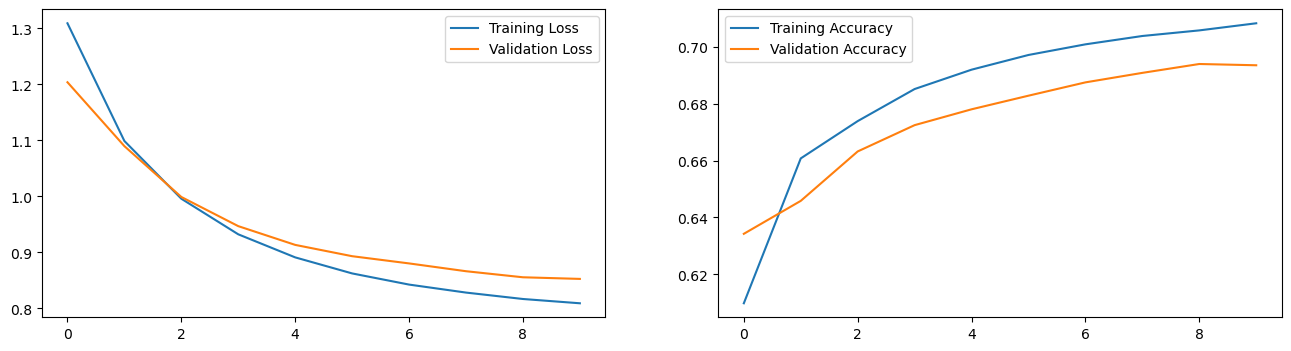

In [276]:
plot_history(history)

In [279]:
y_pred = model.predict(test_dataset)
y_class_pred = np.argmax(y_pred, axis=-1)
y_act = np.concatenate([y for x, y in test_dataset], axis=0)

1288/1288 [==============================] - 11s 8ms/step


### F1 report

In [252]:
print_validation_report(y_act, y_class_pred)

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10769
           1       1.00      1.00      1.00     19061
           2       1.00      1.00      1.00      2196
           3       0.37      0.30      0.33      5360
           4       0.43      0.02      0.04      3576
           5       0.37      0.70      0.48      5108

    accuracy                           0.81     46070
   macro avg       0.70      0.67      0.64     46070
weighted avg       0.81      0.81      0.79     46070

Accuracy Score: 0.8088560885608856
Root Mean Square Error: 0.7280691270667328


## Confusion Matrix

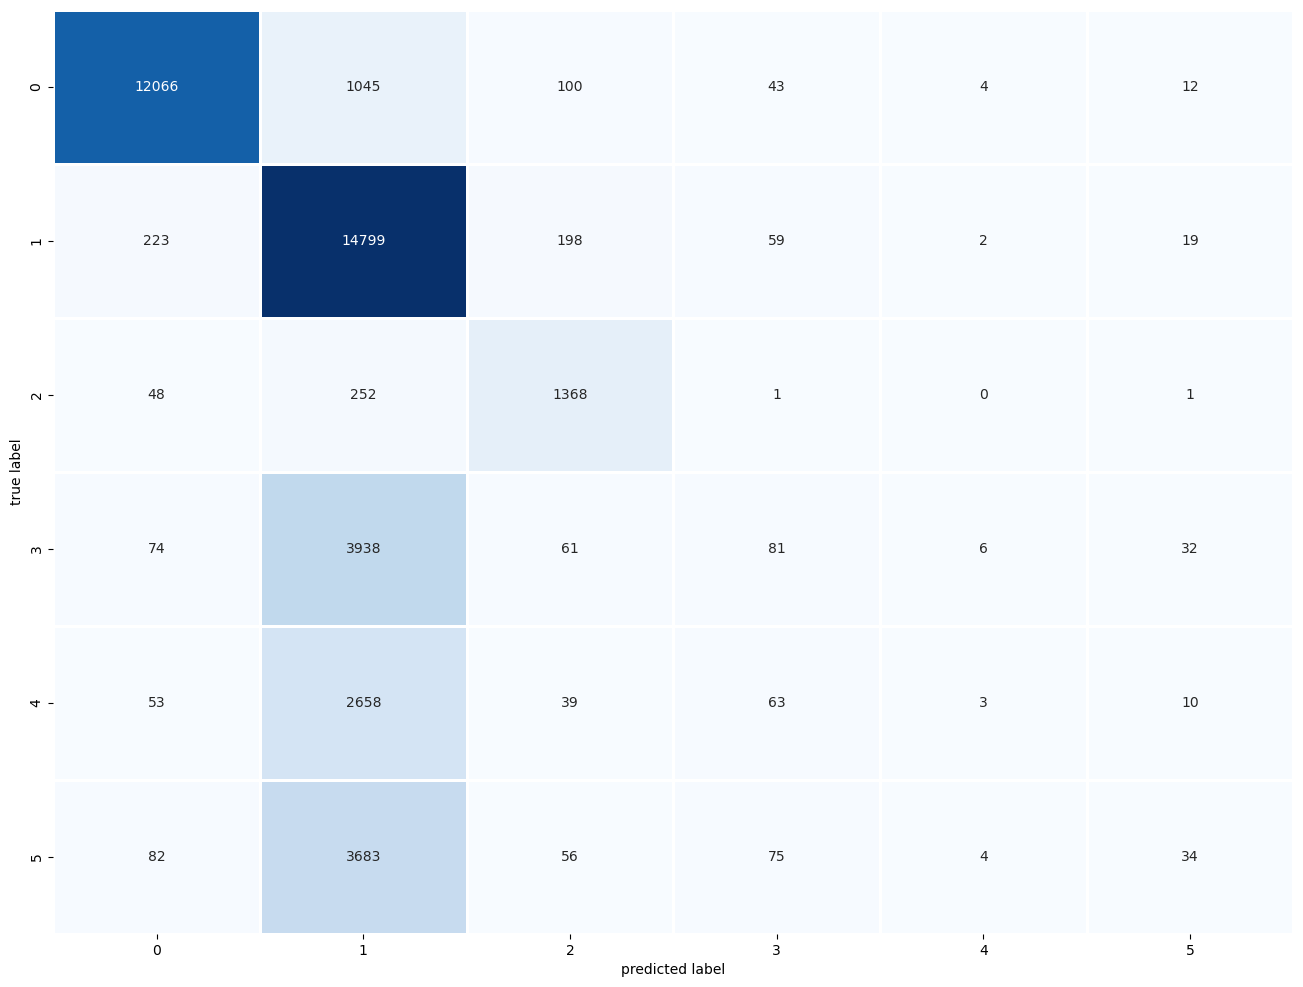

In [280]:
plot_confusion_matrix(y_act, y_class_pred)

Getting FG/punts right, but predicting pass a lot, which makes sense given we didn't do much with the model yet and that is the majority class.

## Random Forest Feature Importances

using a random forest to examine the important multivariate features. Basically building a model to predict the model prediction using a flattened array of sequences. Trying to see which variables may be important, and which ones to potentially discard. This may also help in understanding what sequence length to use.

In [283]:
from sklearn.inspection import permutation_importance

In [284]:
model = keras.models.load_model("m01_lstm.h5")

In [285]:
post_x_test = np.concatenate([x for x, _ in test_dataset], axis=0)
post_y_test = np.concatenate([y for _, y in test_dataset], axis=0)

In [288]:
post_x_test.shape

(41192, 15, 58)

In [302]:
post_x_test_2d = post_x_test.reshape((post_x_test.shape[0], -1))
post_y_test_2d = post_y_test.reshape((post_y_test.shape[0], -1))

In [304]:
870/15

58.0

In [303]:
post_x_test_2d.shape

(41192, 870)

In [313]:
np.ravel(post_y_test_2d).shape

(41192,)

In [314]:
rnd_importance = RandomForestClassifier(n_estimators = 200, random_state=50)
rnd_importance.fit(post_x_test_2d, np.ravel(post_y_test_2d))

RandomForestClassifier(n_estimators=200, random_state=50)

In [360]:
importances = rnd_importance.feature_importances_
print(importances.shape)
print(importances.shape[0]/n_feats)

(870,)
15.0


extract column names that correspond to features. These will be the same as the feature importance values at intervals of n features.

In [323]:
names = df_train.drop(['pt_play_no', 'play_type', 'play_type_encoded', 'game_id', 'posteam'],axis = 1).columns.values

looking at the importances for the features in the last time step 

In [337]:
values = importances[870 - n_feats - 1:870 - 1]
sorted_indices = np.argsort(values)
sorted_values = values[sorted_indices]
sorted_column_names = [names[i] for i in sorted_indices]

Text(0.5, 1.0, 'Bar Chart')

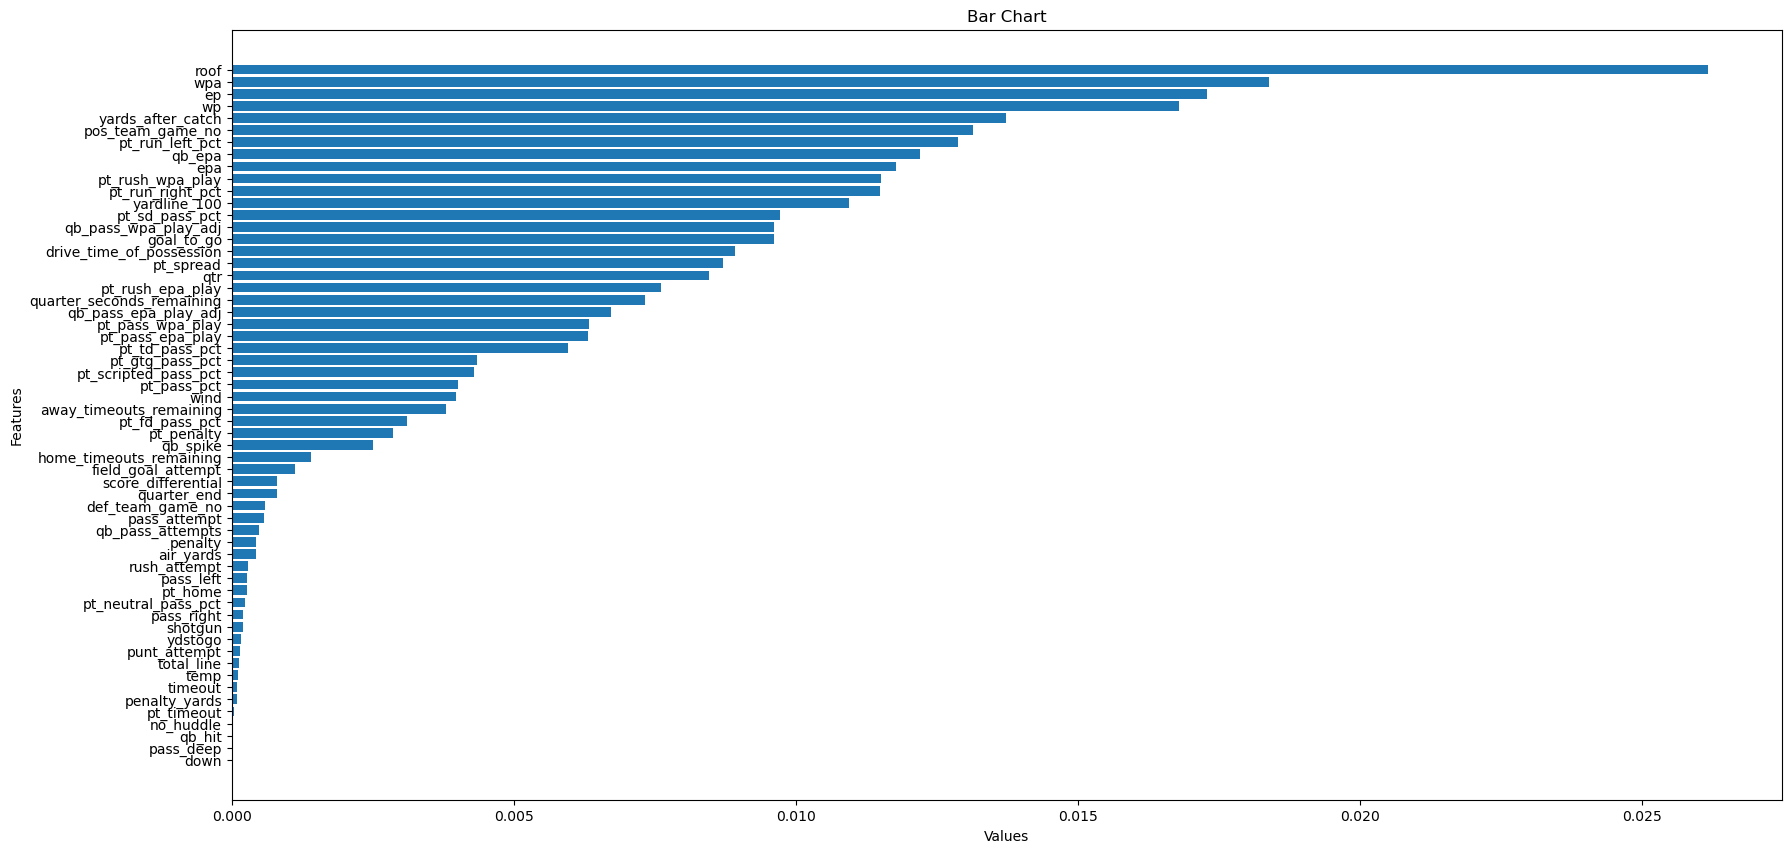

In [338]:
plt.figure(figsize=(20, 10))
plt.barh(range(len(names)), sorted_values)
plt.yticks(range(len(names)), sorted_column_names, rotation=0)
plt.ylabel('Features')
plt.xlabel('Values')
plt.title('Bar Chart')

Now looking at all timesteps

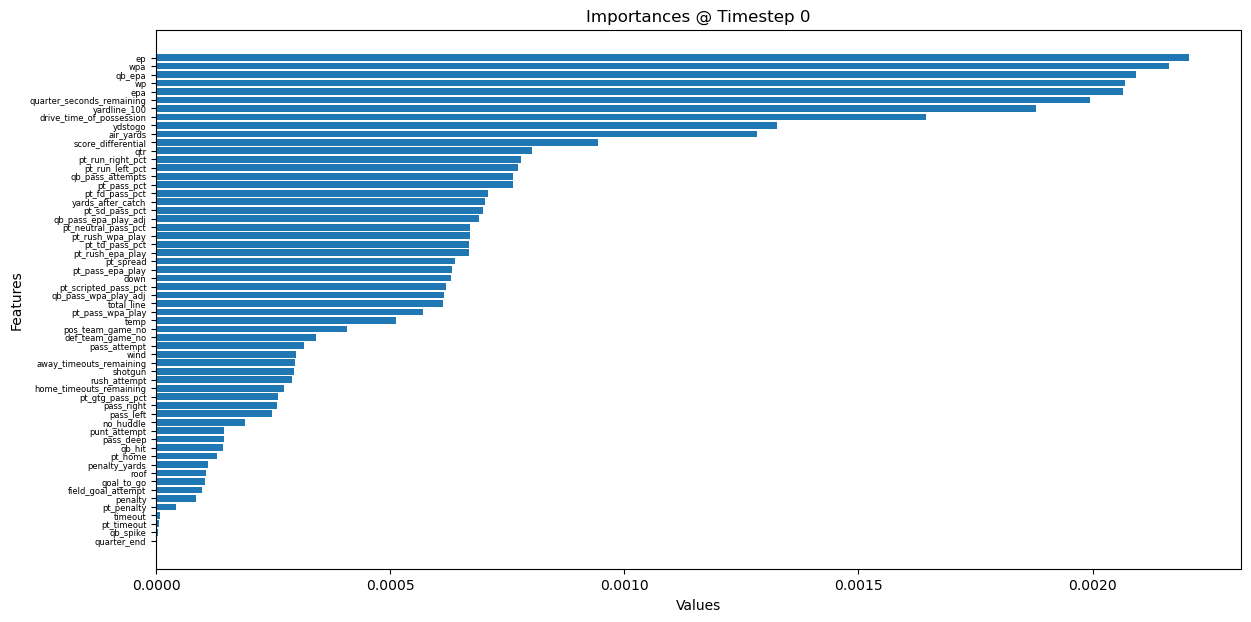

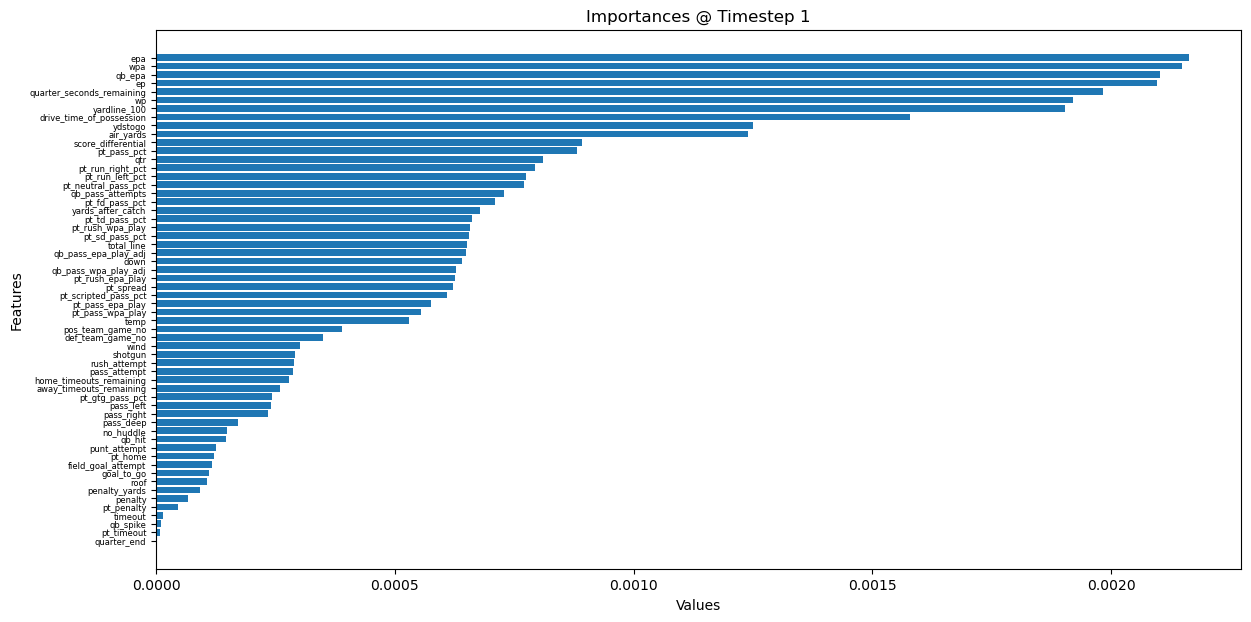

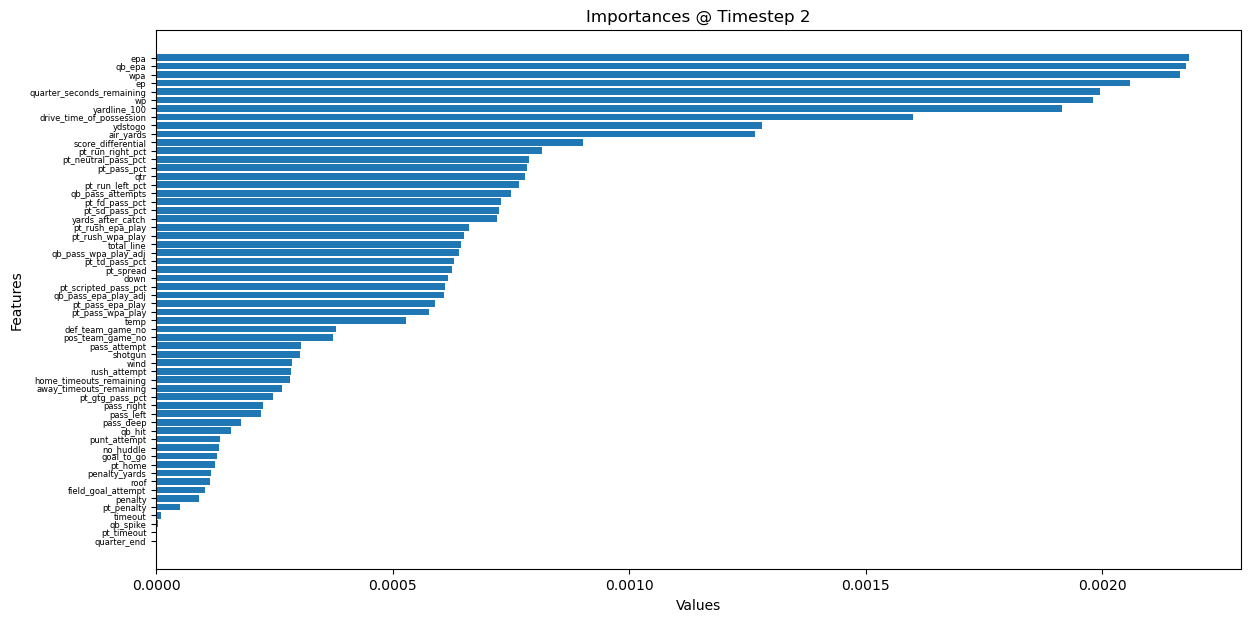

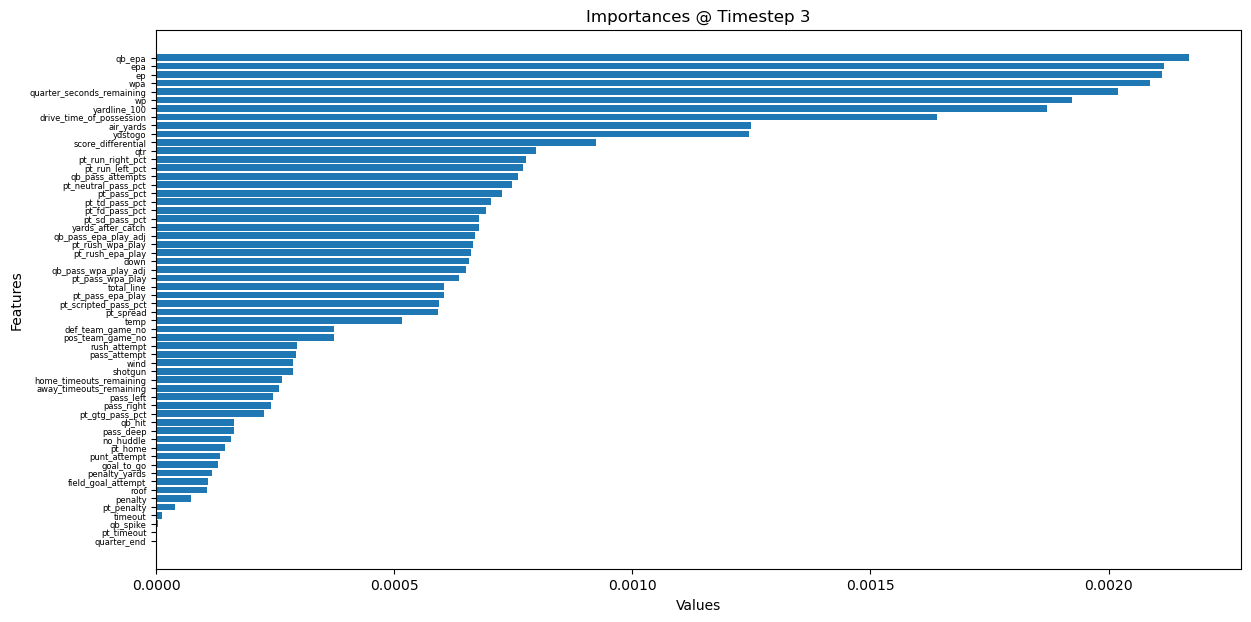

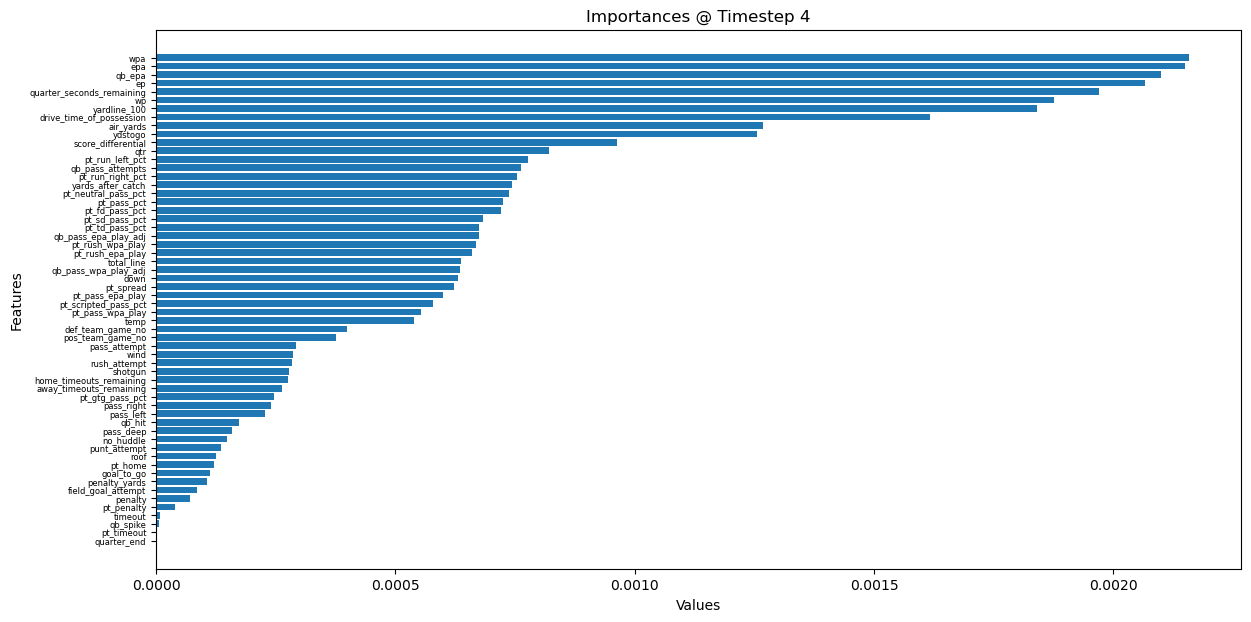

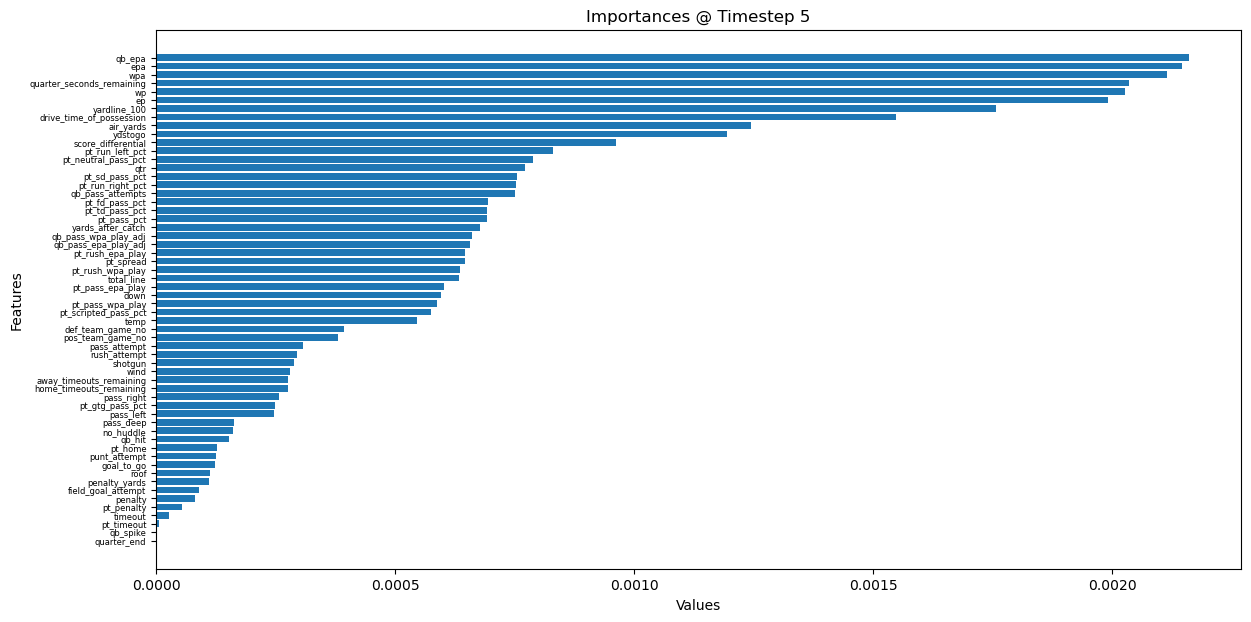

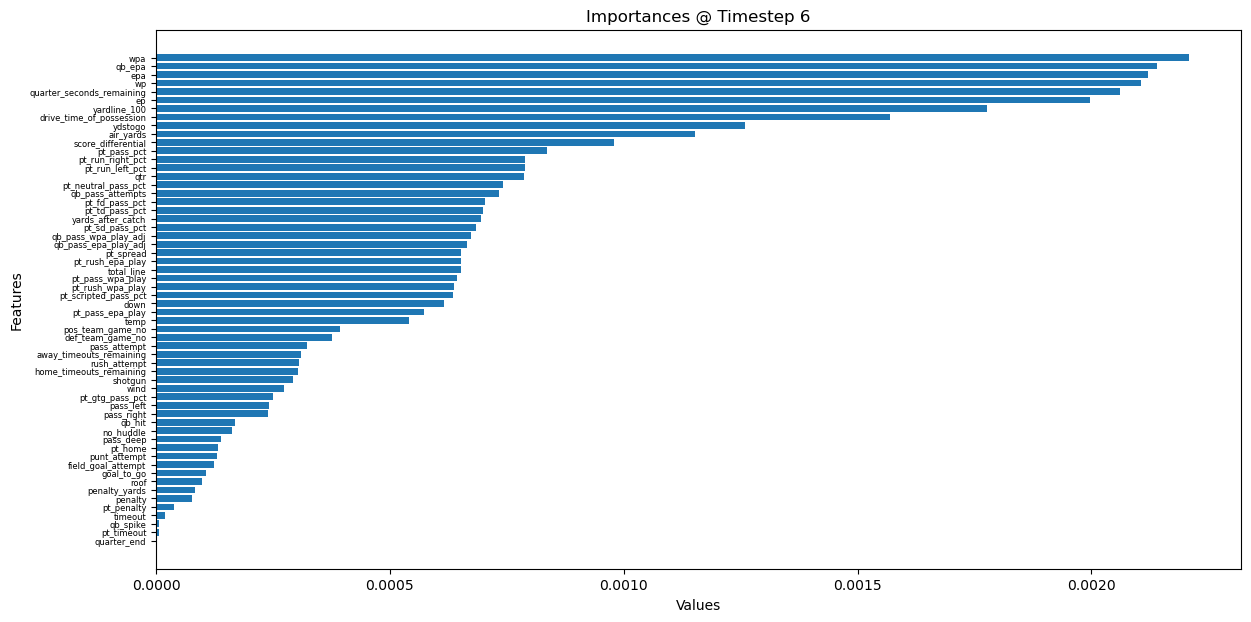

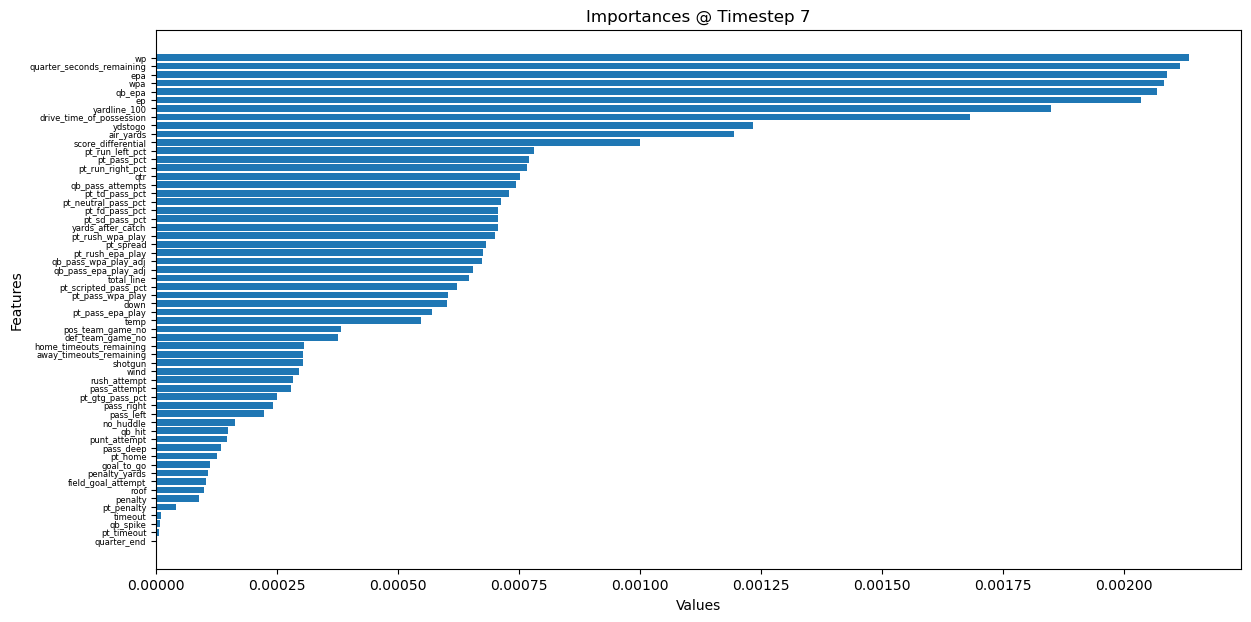

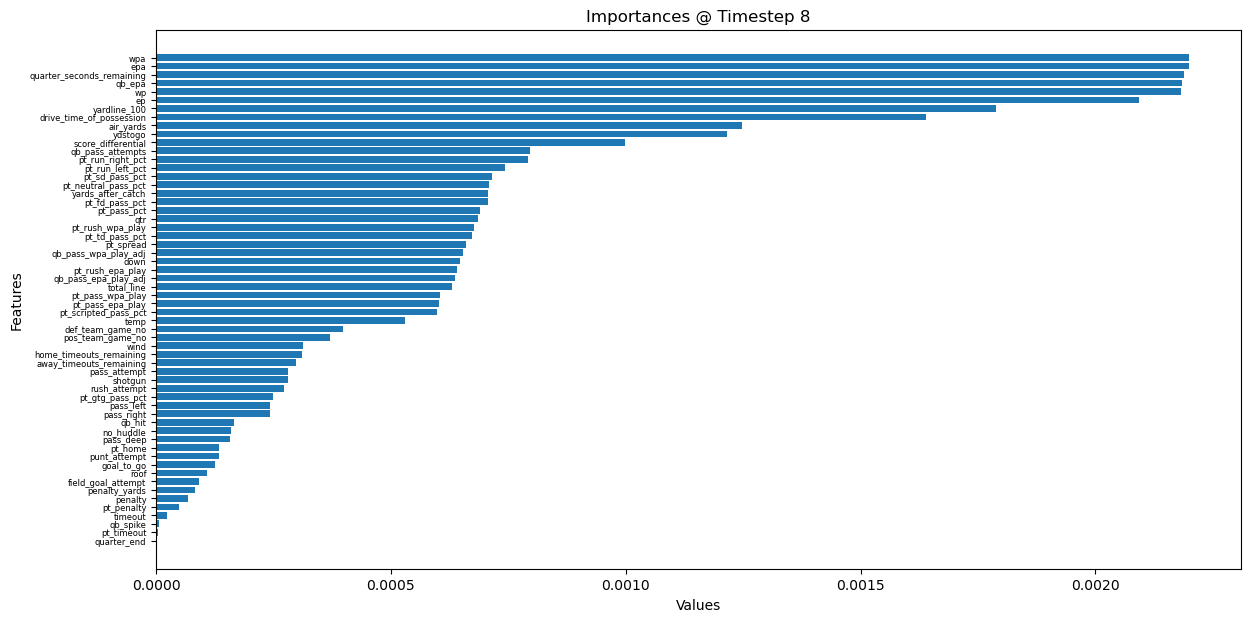

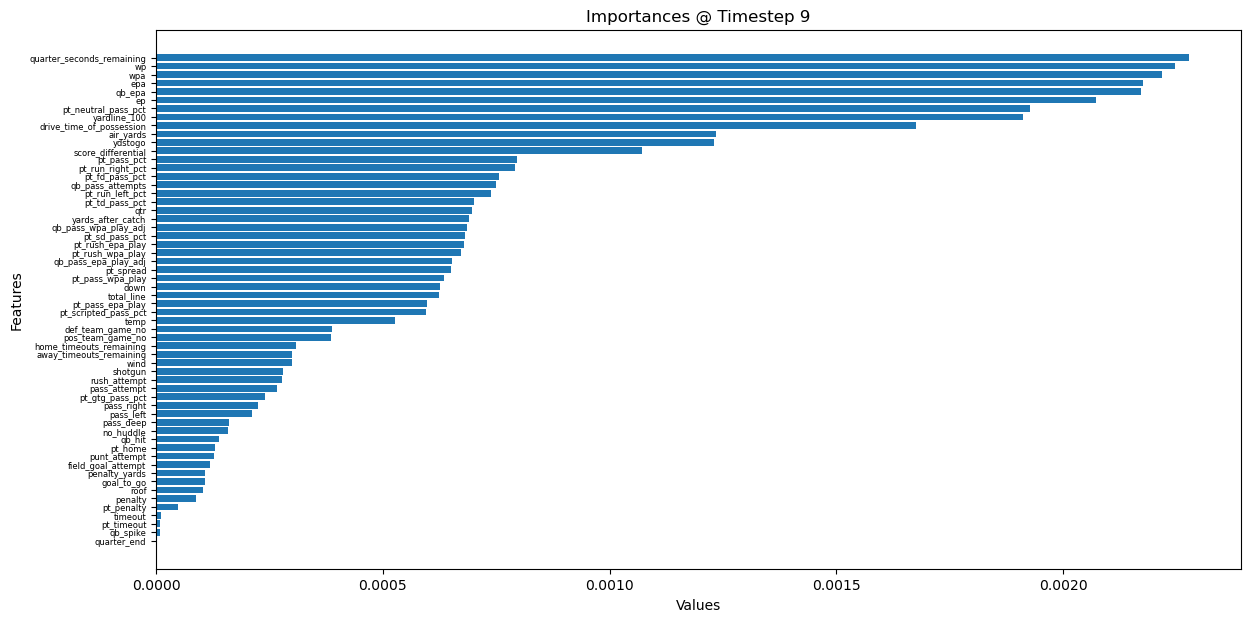

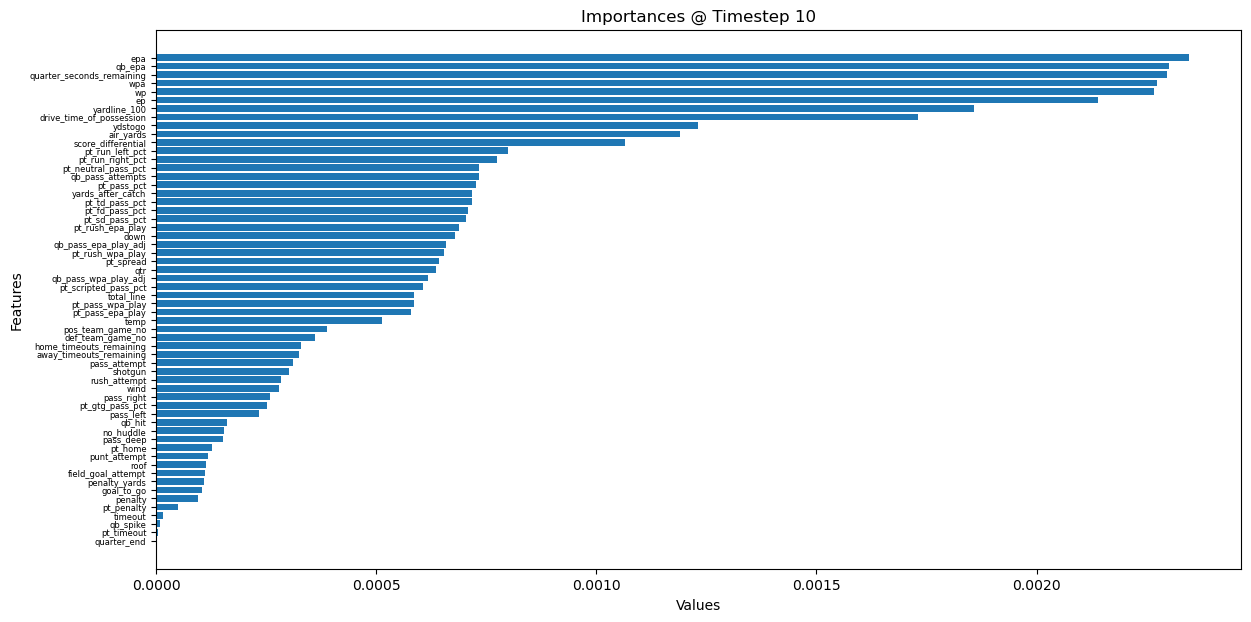

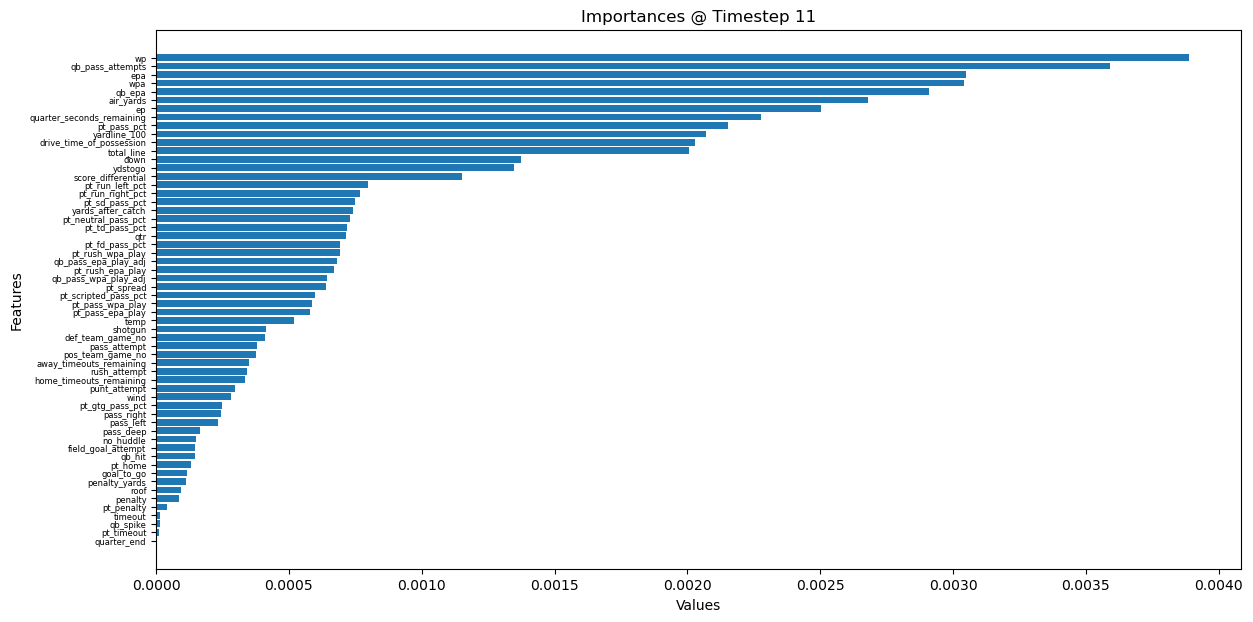

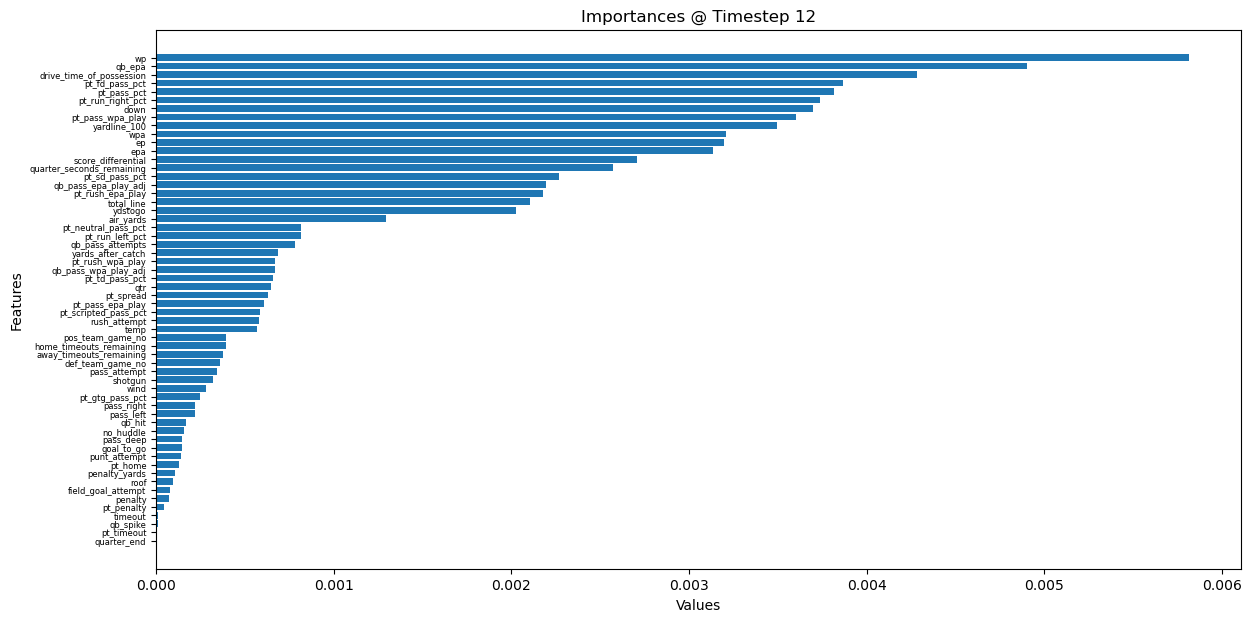

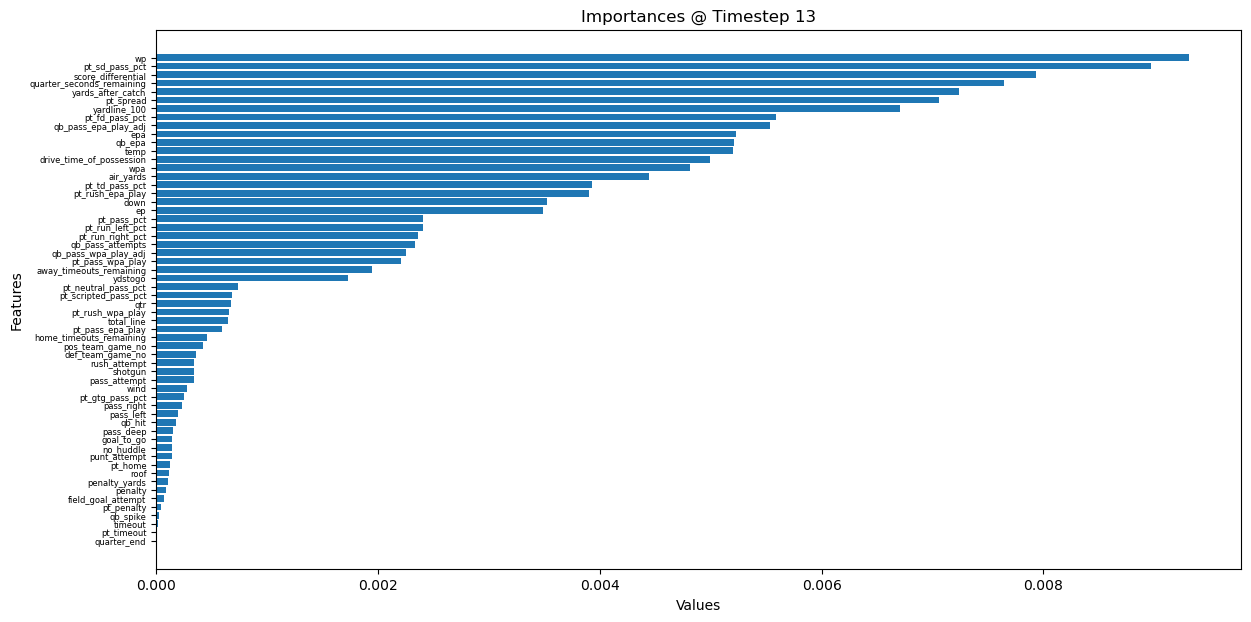

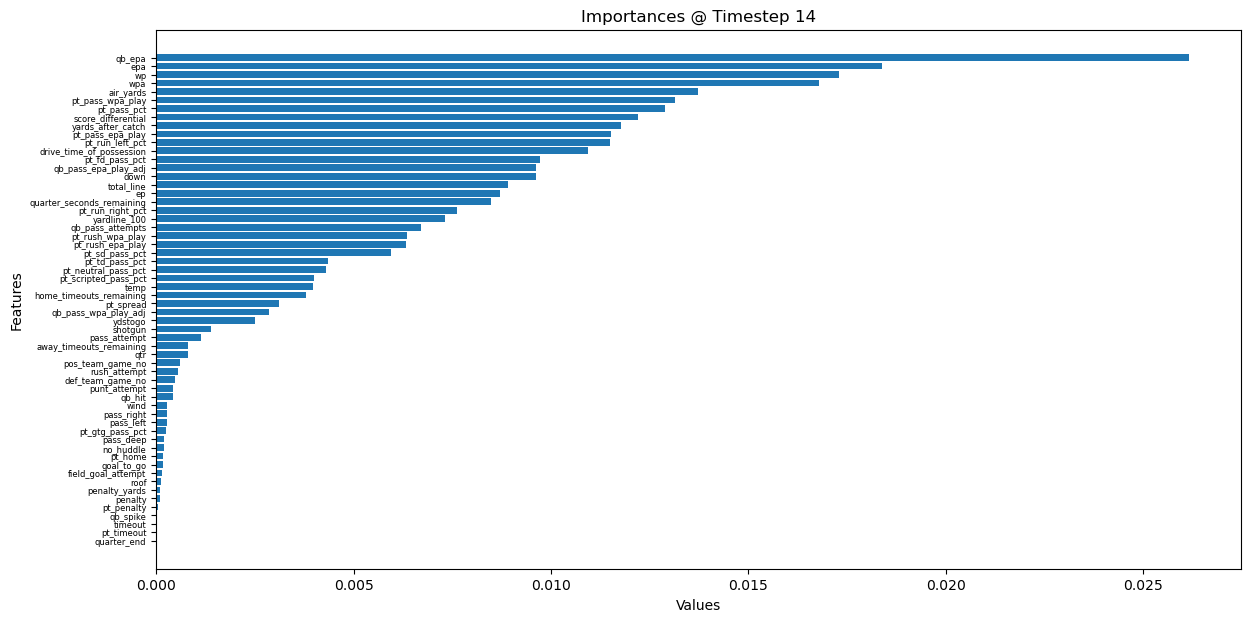

In [363]:
last_index = n_feats
for i in range(sequence_length):
    values = importances[i*n_feats:last_index]
    sorted_indices = np.argsort(values)
    sorted_values = values[sorted_indices]
    sorted_column_names = [names[i] for i in sorted_indices]
    last_index += n_feats
    plt.figure(figsize=(14, 7))
    plt.barh(range(len(names)), sorted_values)
    plt.yticks(range(len(names)), sorted_column_names, rotation=0)
    plt.yticks(fontsize=6)
    plt.ylabel('Features')
    plt.xlabel('Values')
    plt.title(f"Importances @ Timestep {i}")